# Analyze dataset

# 1. Imports

## 1.1 Packages

In [1]:
import os
import sys

from collections import defaultdict
from operator import contains
import pandas as pd

from nltk.util import ngrams
import re
from wordcloud import STOPWORDS


from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Option packages

pd.set_option('display.max_columns', 500)

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

In [3]:
sys.path.append('/Users/Benjamin/Git/Kaggle/nlp_disaster_tweets/src')
from features.build_features import word_count_tweet, unique_word_count_tweet, url_count_tweet, mean_word_length_tweet,\
    char_count_tweet, punctuation_count_tweet, hashtag_count_tweet, mention_count_tweet

## 1.2 Options

In [4]:
path_data = '../data/raw/'

## 1.2 Datasets

In [5]:
df = pd.read_csv(os.path.join(path_data, 'train.csv'), index_col=0)

In [6]:
df.sample(2)

,keyword,location,text,target
id,,,,
1024,blazing,NaN,Follow @EdWelchMusic and check out his Hit Sin...,0
1474,body%20bagging,401 livin',Aubrey really out here body-bagging Meek.,1


# 2. Analyze data

In [7]:
print('Shape of the dataset', df.shape)

Shape of the dataset (7613, 4)


## 2.1 Keyword and location

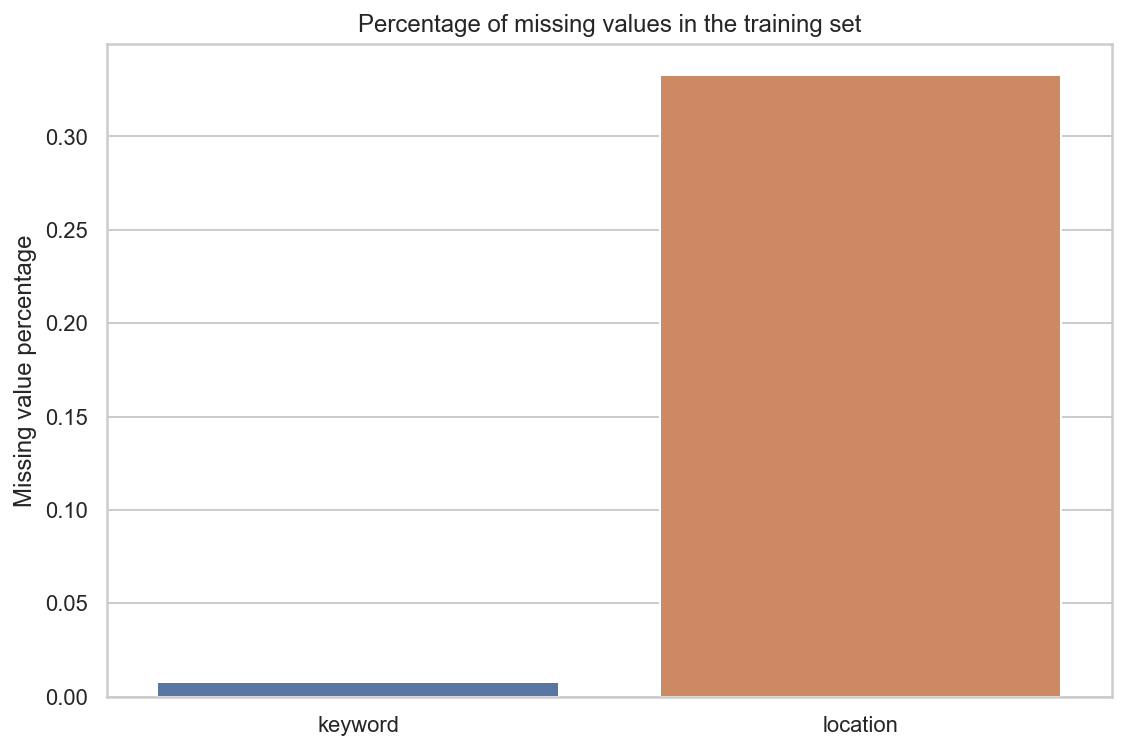

In [8]:
feats = ['keyword', 'location']

fig, ax = plt.subplots(figsize=(9, 6))
sns.barplot(x=df[feats].isna().sum().index, y=(df[feats].isna().sum() / df.shape[0]).values, ax=ax)
ax.set_ylabel('Missing value percentage')
ax.set_title('Percentage of missing values in the training set')

plt.show()

More than 30% of the locations are missing in the dataset.

In [9]:
n_unique_key = df.keyword.nunique()
n_unique_loc = df.location.nunique()

print('Number of unique values for the keyword feature: ', n_unique_key)
print('Number of unique values for the location feature:', n_unique_loc)

Number of unique values for the keyword feature:  221
Number of unique values for the location feature: 3341


In [10]:
df.keyword.value_counts(dropna=False)

NaN                      61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [11]:
df.location.value_counts(dropna=False)

NaN                             2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

## 2.2 Tweets info

In [12]:
df.iloc[2]['text']

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [13]:
df = df.pipe(word_count_tweet)\
    .pipe(unique_word_count_tweet)\
    .pipe(url_count_tweet)\
    .pipe(mean_word_length_tweet)\
    .pipe(char_count_tweet)\
    .pipe(punctuation_count_tweet)\
    .pipe(hashtag_count_tweet)\
    .pipe(mention_count_tweet)

In [14]:
df.sample(5)

,keyword,location,text,target,word_count,unique_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
id,,,,,,,,,,,,
8256,rioting,Serva Fidem,Leeds fan.... rioting in Embra at a lower tier...,1,15,15,0,4.133333,76,8,0,0
9831,trauma,NaN,@AshGhebranious civil rights continued in the ...,0,20,19,0,6.000000,139,5,0,1
2374,collapsed,NaN,Zimbabwe is a country with a collapsed governm...,0,19,17,0,4.789474,109,1,0,0
1018,blazing,Swag Francisco,@asukager magical bag of blazing,0,5,5,0,5.600000,32,1,0,1
10553,windstorm,"Gettysburg, PA",#NowPlaying School Of Seven Bells - Windstorm ...,0,8,8,0,5.500000,51,3,2,0


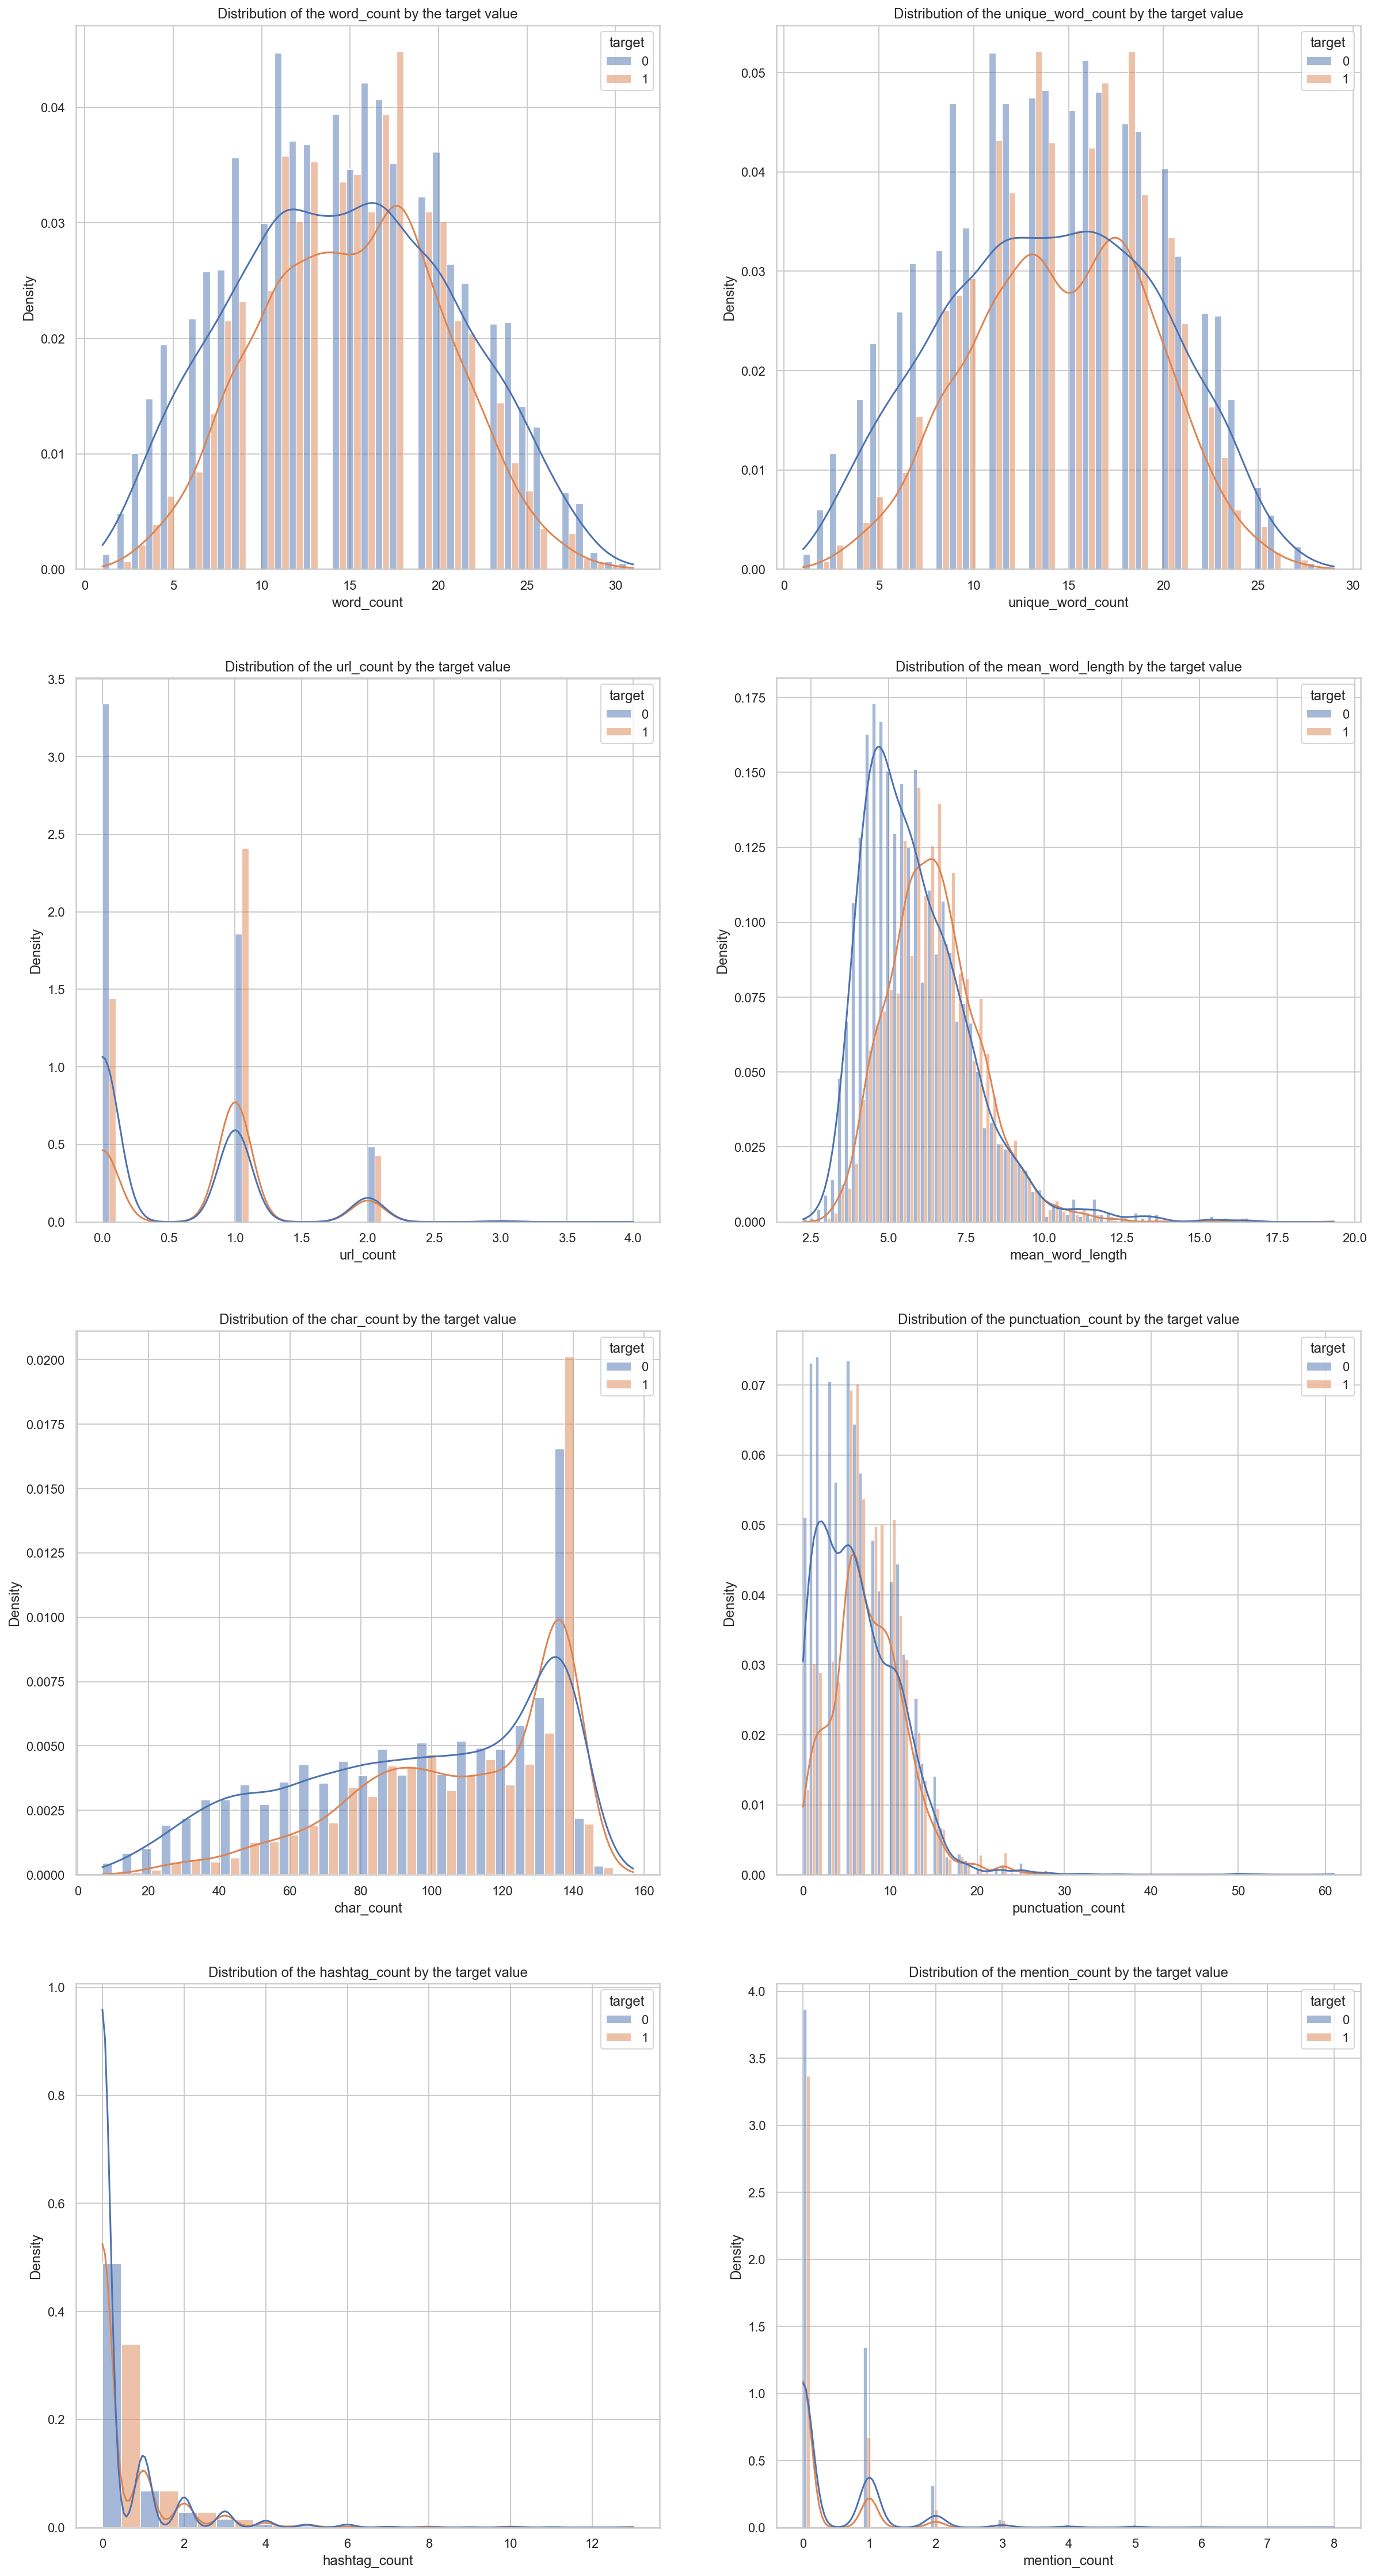

In [15]:
# Plot distribution of tweet info

feat_tweet_info = [
    'word_count', 'unique_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count'
]

fig, axes = plt.subplots(ncols=2, nrows=len(feat_tweet_info)//2, figsize=(20, 40))
axes = axes.flat
for idx, feature in enumerate(feat_tweet_info):
    sns.histplot(data=df, x=feature, hue='target', ax=axes[idx], multiple='dodge', stat='density', kde=True)
    axes[idx].set_title(f'Distribution of the {feature} by the target value')

## 2.3 Target
### 2.3.1 Analyze target

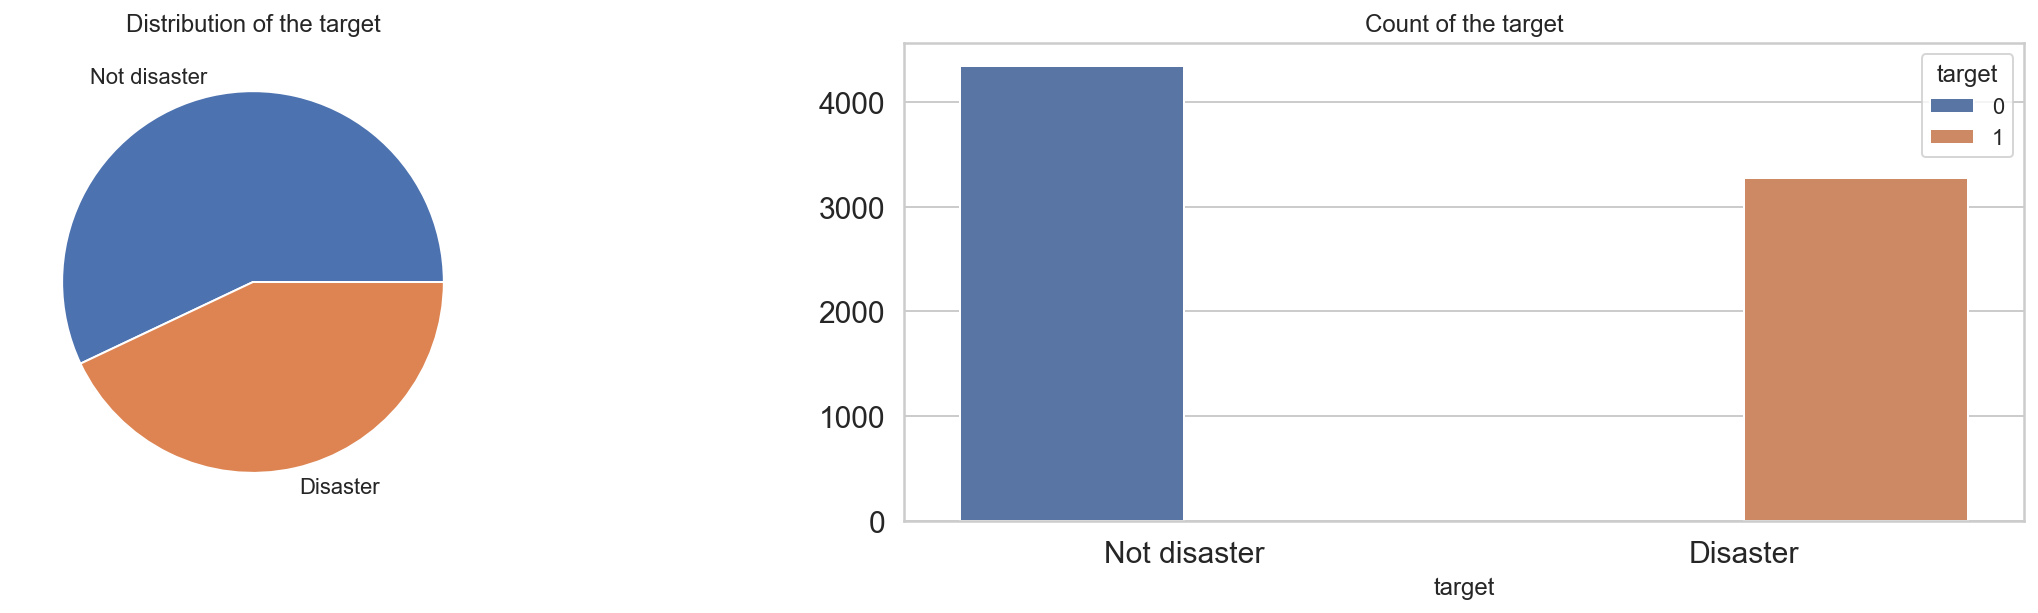

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4))
plt.tight_layout()

df.groupby('target').count()['text'].plot(kind='pie', ax=axes[0], labels=['Not disaster', 'Disaster'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].set_title('Distribution of the target')

axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].set_xticklabels(['Not disaster', 'Disaster'])
axes[1].set_title('Count of the target')

plt.show()

### 2.3.2 N-grams by target

In [17]:
def generate_n_grams(text: str, n_gram: int, stop_words: List[str]=[]) -> List[str]:
    """
    """
    text = text.lower()
    # text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # text = re.sub('[\.\?\,]', ' ', text)
    tokens = [token for token in text.split(" ") if ((token != "") & (token not in stop_words))]
    output = list(ngrams(tokens, n_gram))
    return output


def create_df_n_grams(df: pd.DataFrame, n_gram: int, stop_words: List[str]=[]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    """
    disaster_n_gram = defaultdict(int)
    nondisaster_n_gram = defaultdict(int)
    for tweet in df[df['target'] == 1]['text']:
        for word in generate_n_grams(tweet, n_gram=n_gram, stop_words=stop_words):
            disaster_n_gram[word] += 1

    for tweet in df[df['target'] == 0]['text']:
        for word in generate_n_grams(tweet, n_gram=n_gram, stop_words=stop_words):
            nondisaster_n_gram[word] += 1

    df_disaster_n_gram = pd.DataFrame(sorted(disaster_n_gram.items(), key=lambda x: x[1])[::-1], columns=['n_gram', 'occ'])
    df_nondisaster_n_gram = pd.DataFrame(sorted(nondisaster_n_gram.items(), key=lambda x: x[1])[::-1], columns=['n_gram', 'occ'])
    return df_disaster_n_gram, df_nondisaster_n_gram

In [18]:
# STOPWORDS = [
#     'the', 'at', 'in'
# ]

In [19]:
df_disaster_unigrams, df_nondisaster_unigrams = create_df_n_grams(df, n_gram=1, stop_words=STOPWORDS)

df_disaster_bigrams, df_nondisaster_bigrams = create_df_n_grams(df, n_gram=2, stop_words=STOPWORDS)

df_disaster_trigrams, df_nondisaster_trigrams = create_df_n_grams(df, n_gram=3, stop_words=STOPWORDS)

In [20]:
df_disaster_trigrams

,n_gram,occ
0,"(suicide, bomber, detonated)",30
1,"(bomber, detonated, bomb)",28
2,"(pkk, suicide, bomber)",28
3,"(homes, razed, northern)",28
4,"(latest:, homes, razed)",28
...,...,...
23265,"(allah, forgive, us)",1
23266,"(may, allah, forgive)",1
23267,"(#earthquake, may, allah)",1
23268,"(reason, #earthquake, may)",1


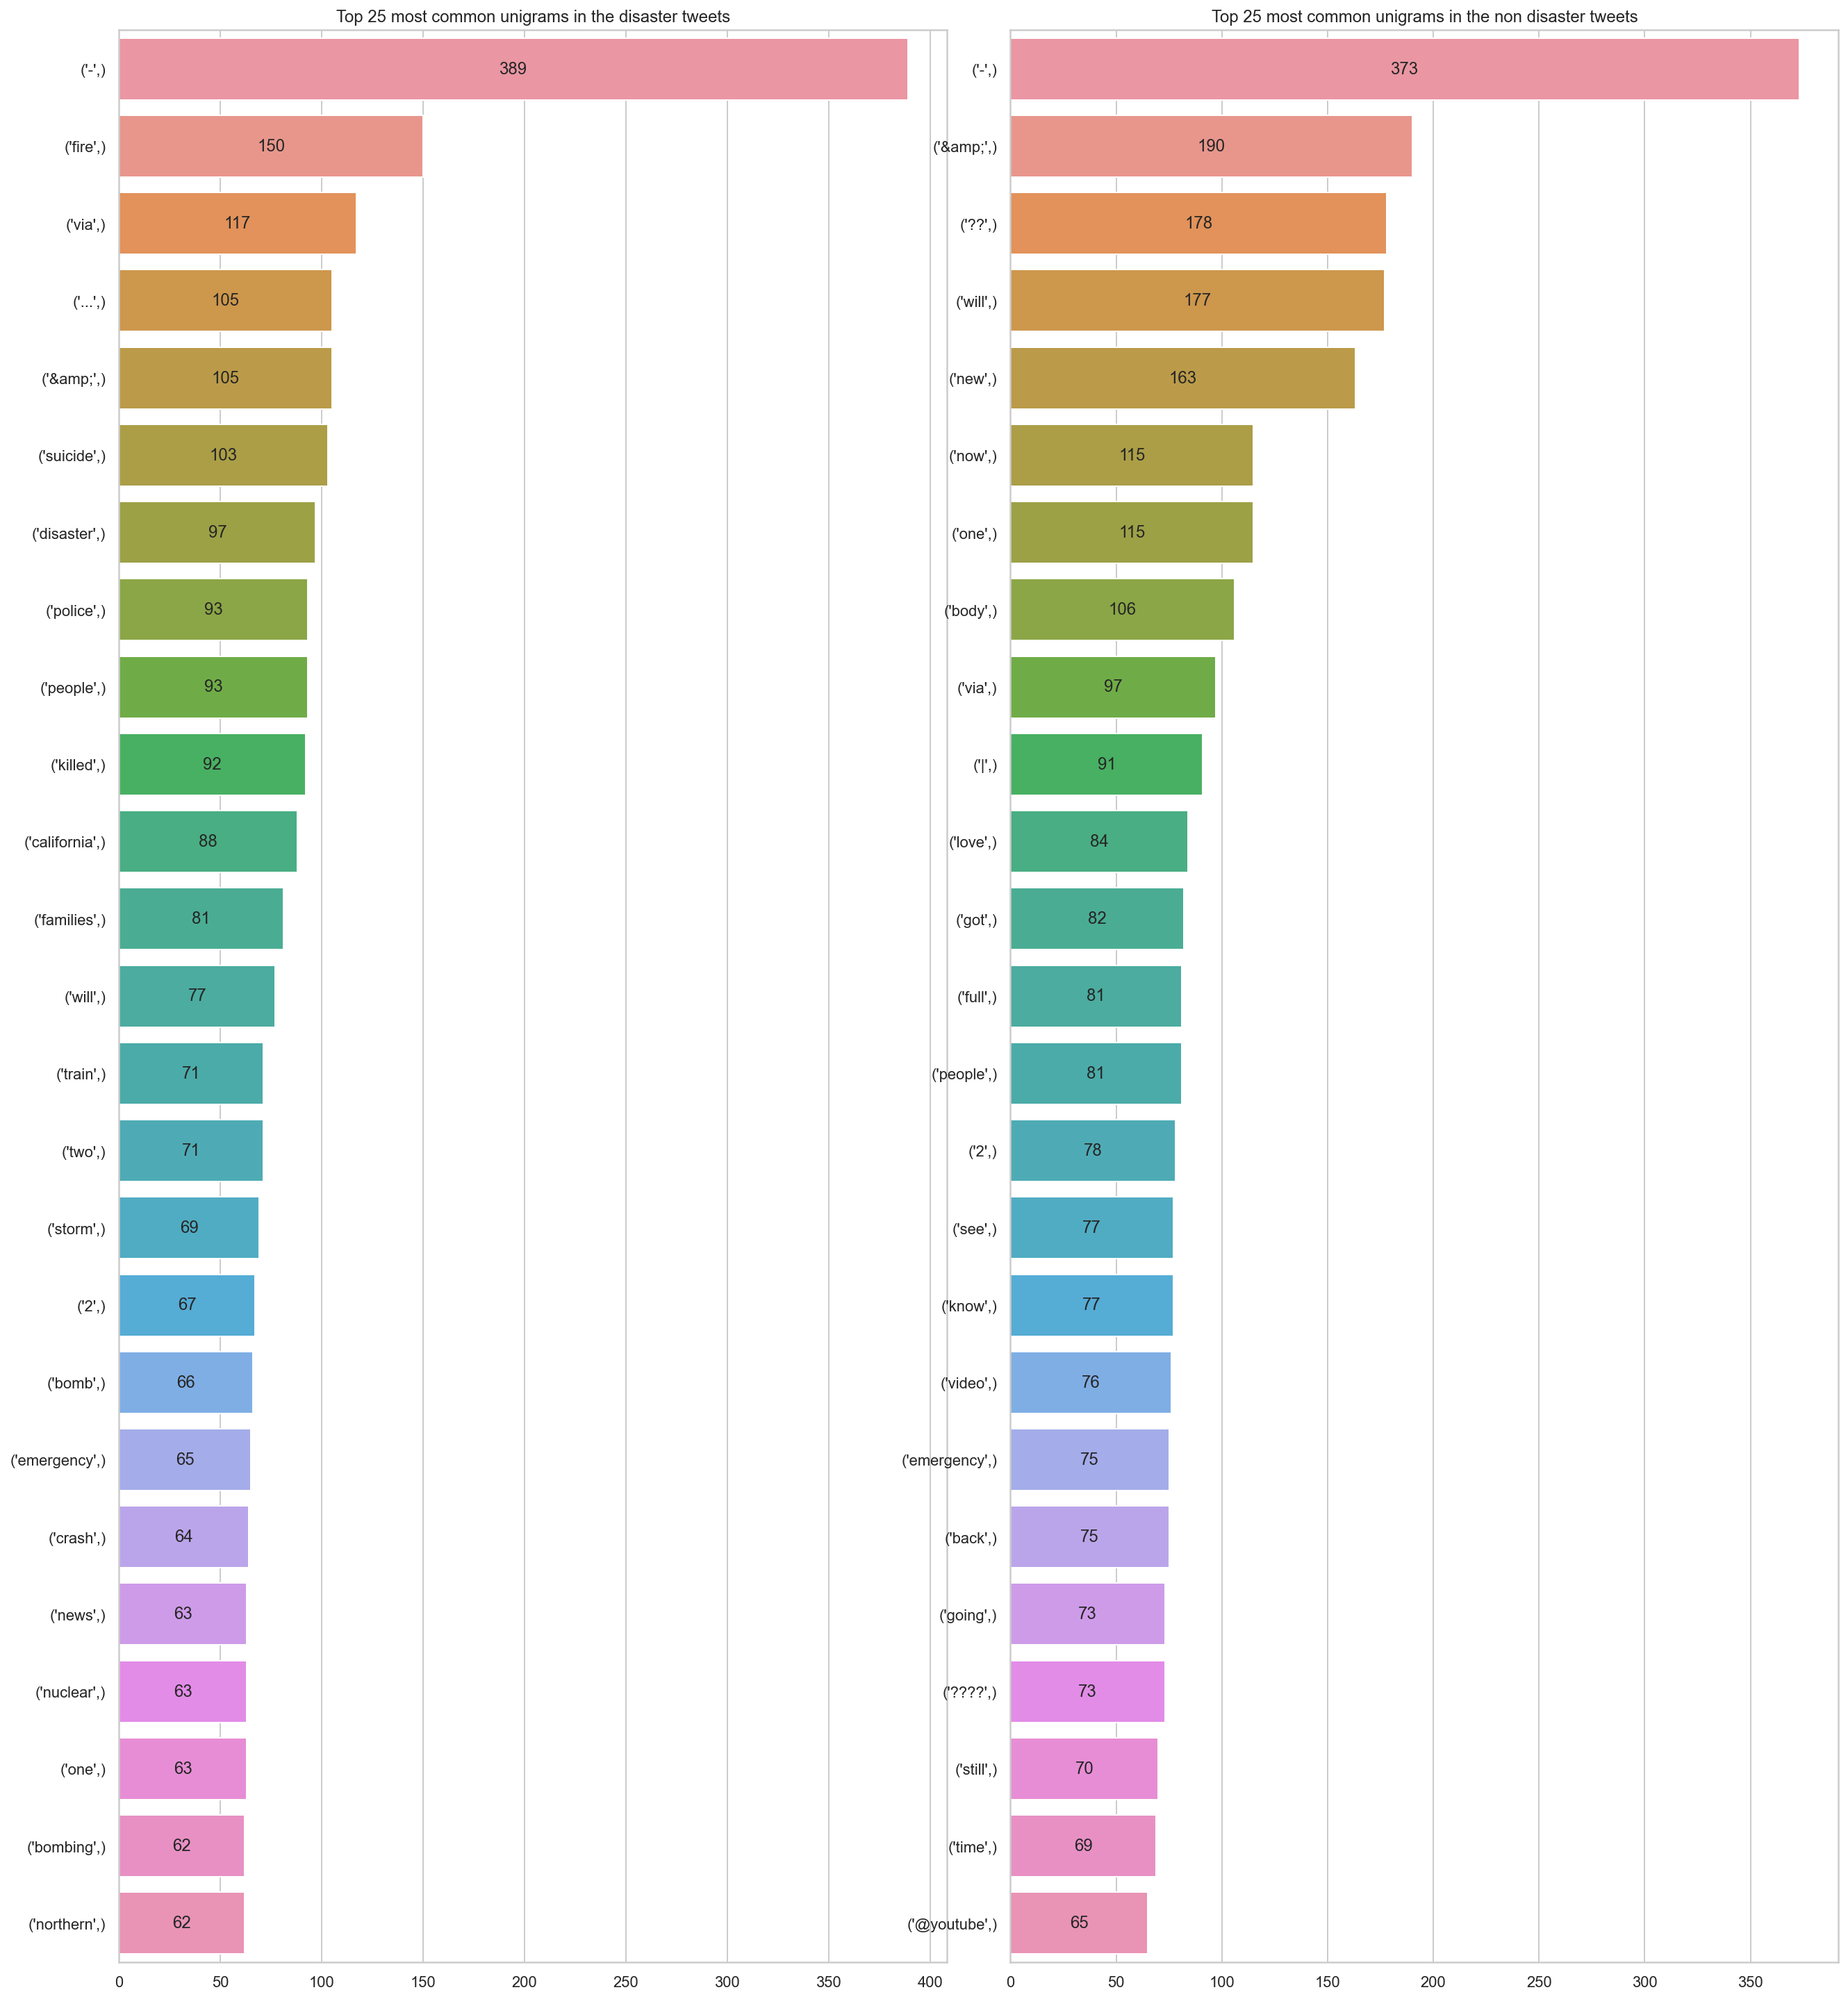

In [21]:
n_to_plot: int=25

fig, axes = plt.subplots(ncols=2, figsize=(18, 20))
plt.tight_layout()

sns.barplot(x=df_disaster_unigrams['occ'].values[:n_to_plot], y=df_disaster_unigrams['n_gram'].values[:n_to_plot], ax=axes[0])
sns.barplot(x=df_nondisaster_unigrams['occ'].values[:n_to_plot], y=df_nondisaster_unigrams['n_gram'].values[:n_to_plot], ax=axes[1])

axes[0].set_title(f'Top {n_to_plot} most common unigrams in the disaster tweets')
axes[1].set_title(f'Top {n_to_plot} most common unigrams in the non disaster tweets')

axes[0].bar_label(container=axes[0].containers[0], label_type='center')
axes[1].bar_label(container=axes[1].containers[0], label_type='center')

plt.show()

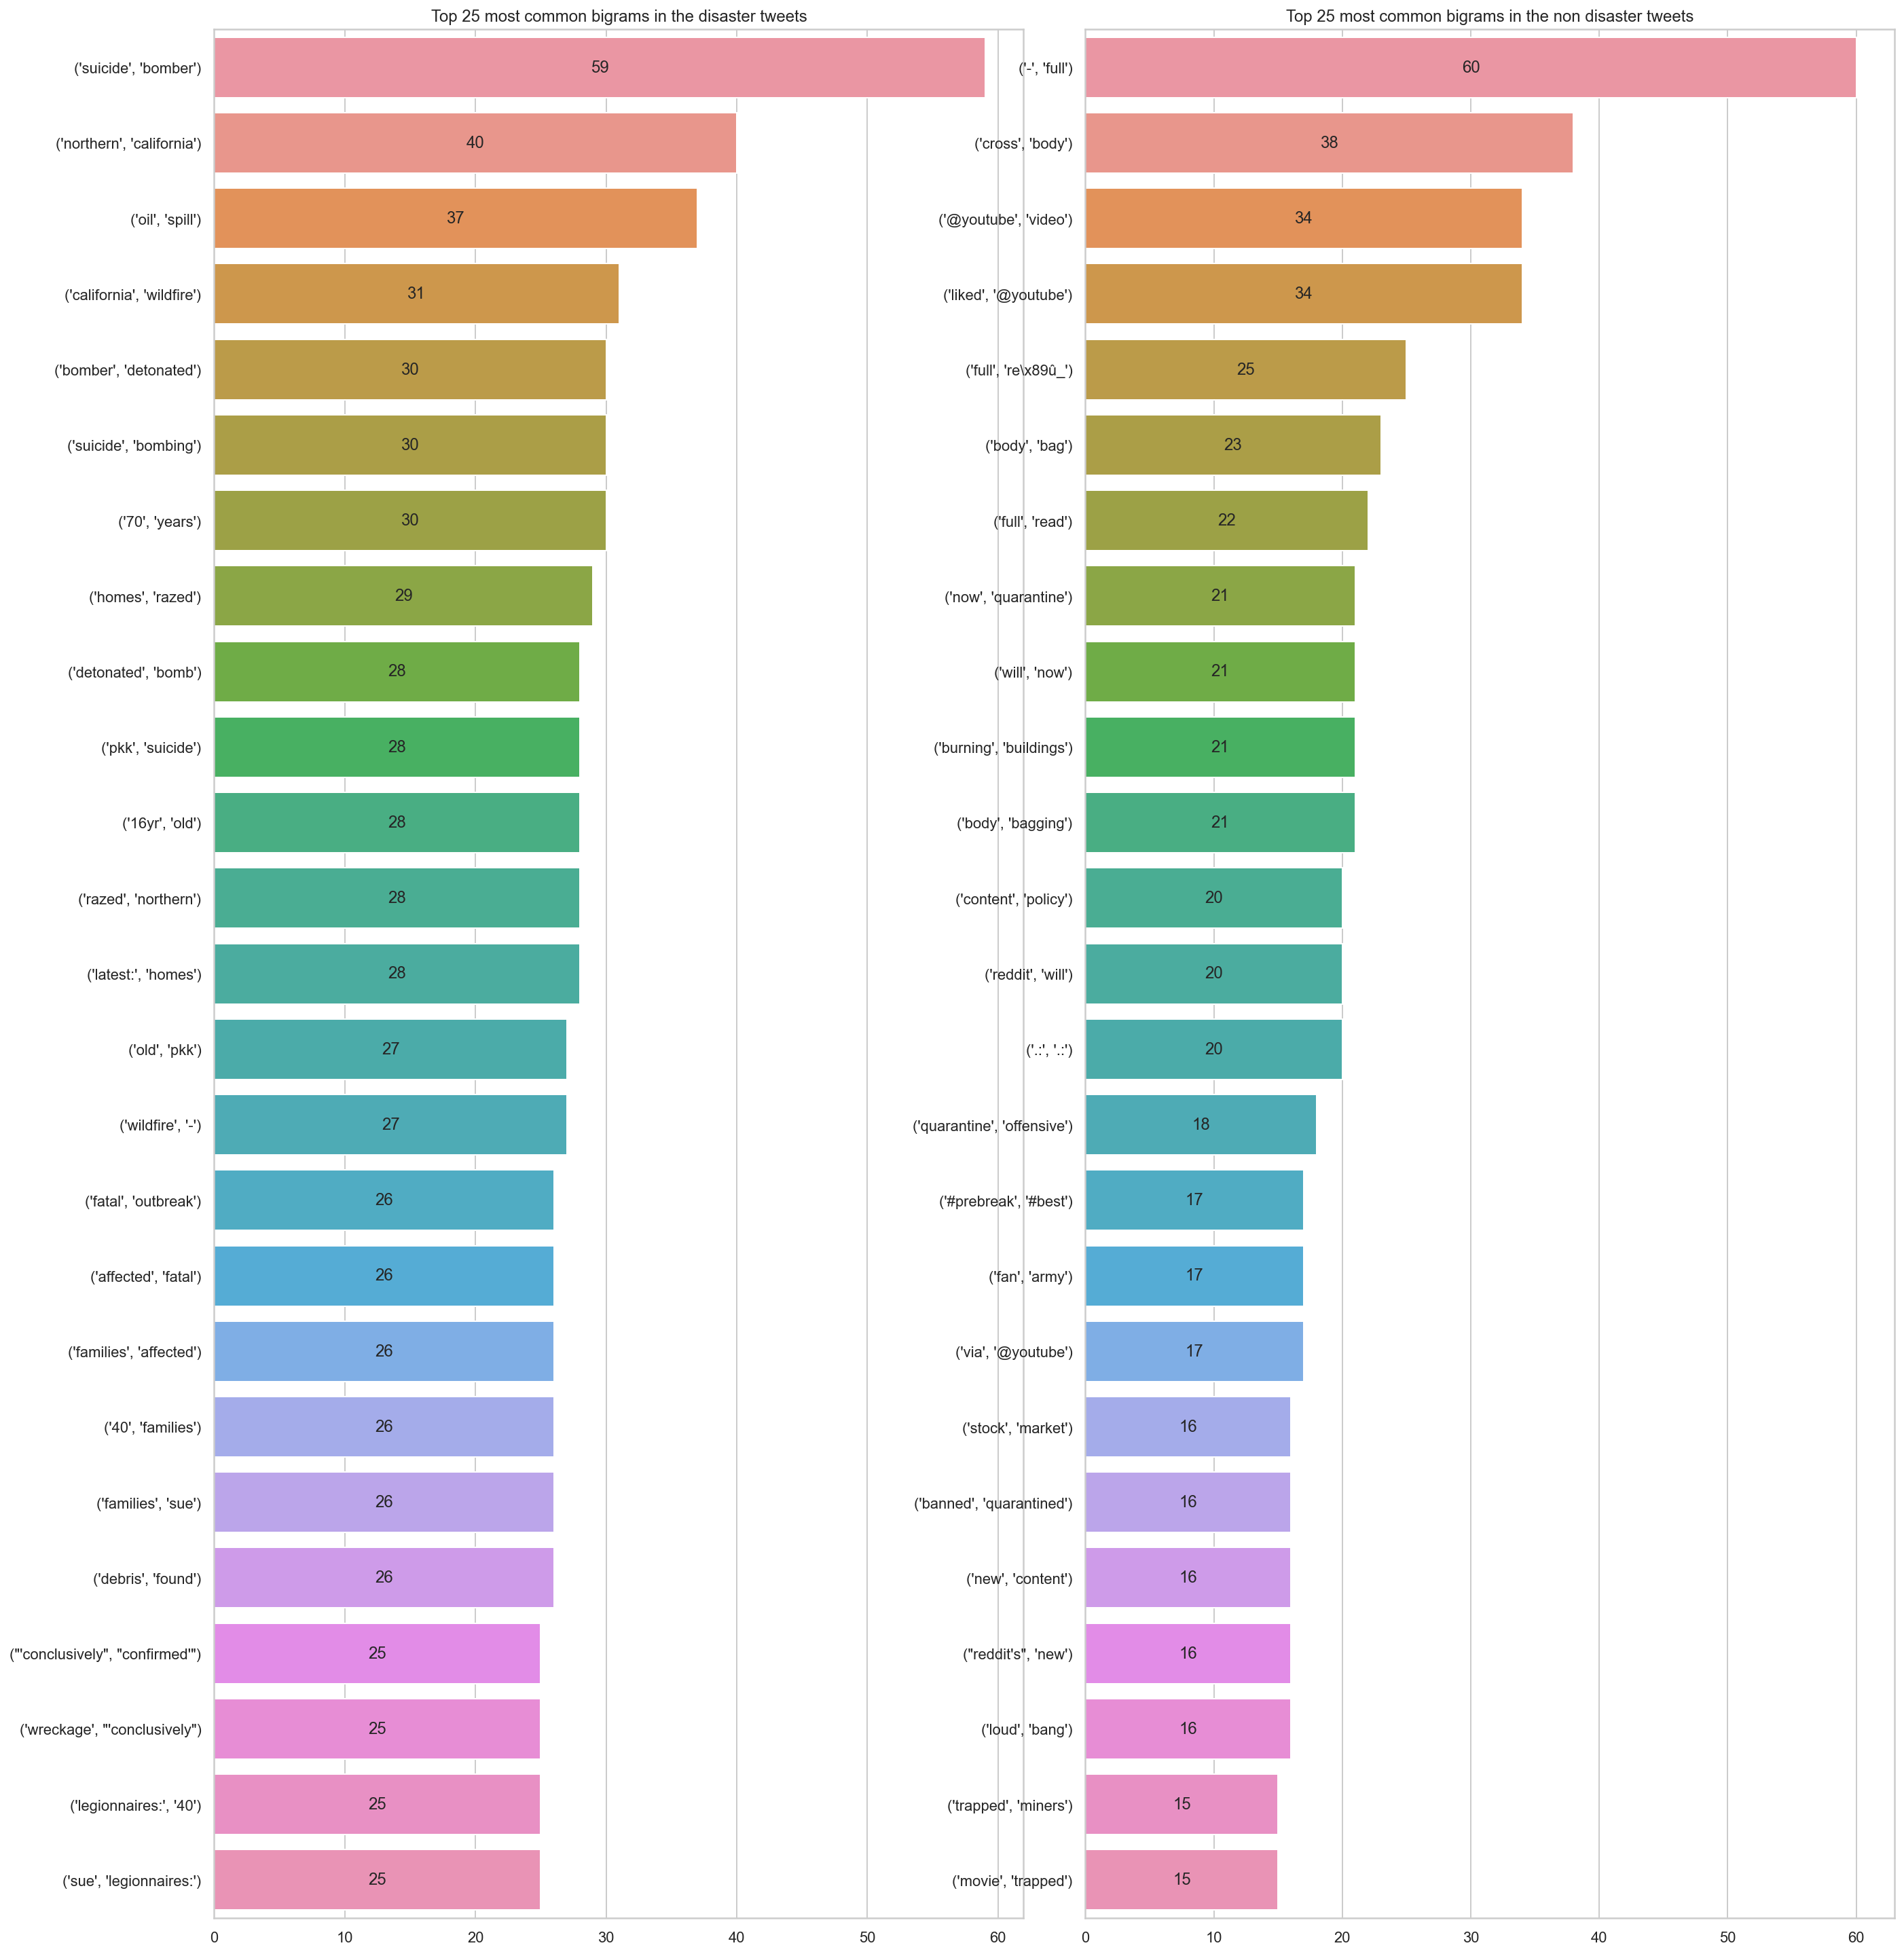

In [22]:
n_to_plot: int=25

fig, axes = plt.subplots(ncols=2, figsize=(18, 20))
plt.tight_layout()

sns.barplot(x=df_disaster_bigrams['occ'].values[:n_to_plot], y=df_disaster_bigrams['n_gram'].values[:n_to_plot], ax=axes[0])
sns.barplot(x=df_nondisaster_bigrams['occ'].values[:n_to_plot], y=df_nondisaster_bigrams['n_gram'].values[:n_to_plot], ax=axes[1])

axes[0].set_title(f'Top {n_to_plot} most common bigrams in the disaster tweets')
axes[1].set_title(f'Top {n_to_plot} most common bigrams in the non disaster tweets')

axes[0].bar_label(container=axes[0].containers[0], label_type='center')
axes[1].bar_label(container=axes[1].containers[0], label_type='center')

plt.show()

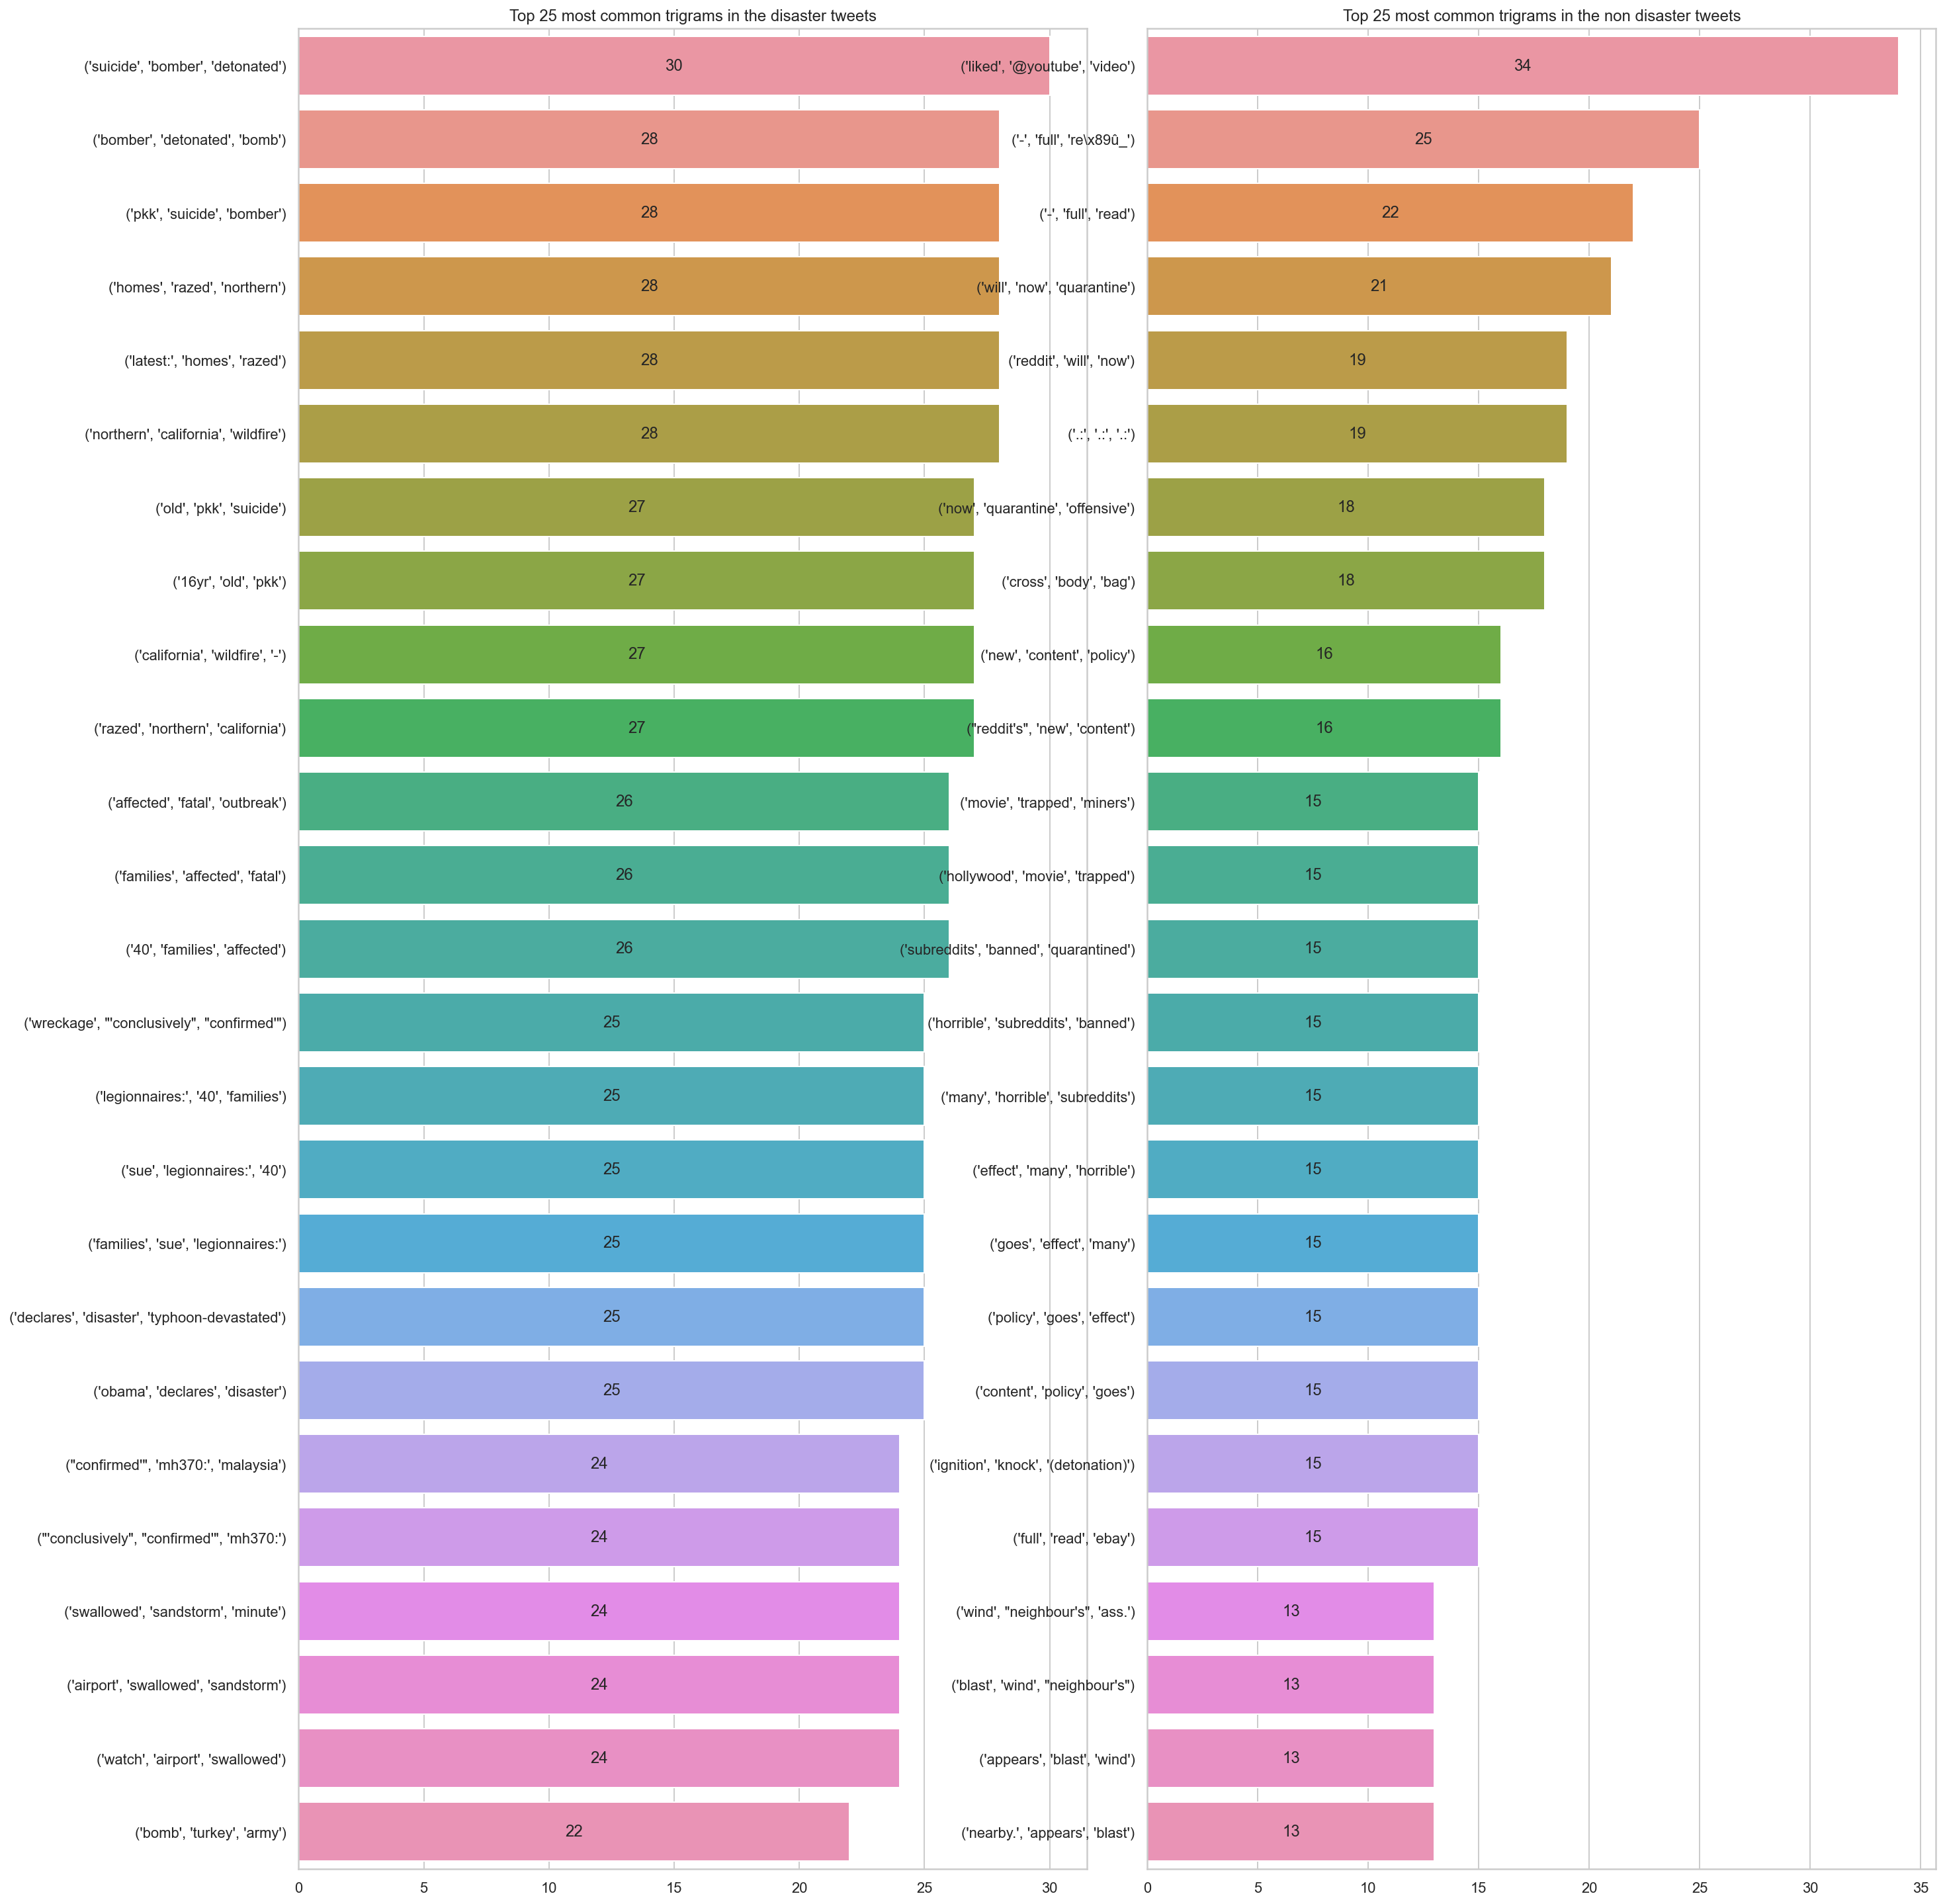

In [23]:
n_to_plot: int=25

fig, axes = plt.subplots(ncols=2, figsize=(18, 20))
plt.tight_layout()

sns.barplot(x=df_disaster_trigrams['occ'].values[:n_to_plot], y=df_disaster_trigrams['n_gram'].values[:n_to_plot], ax=axes[0])
sns.barplot(x=df_nondisaster_trigrams['occ'].values[:n_to_plot], y=df_nondisaster_trigrams['n_gram'].values[:n_to_plot], ax=axes[1])

axes[0].set_title(f'Top {n_to_plot} most common trigrams in the disaster tweets')
axes[1].set_title(f'Top {n_to_plot} most common trigrams in the non disaster tweets')

axes[0].bar_label(container=axes[0].containers[0], label_type='center')
axes[1].bar_label(container=axes[1].containers[0], label_type='center')

plt.show()